In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Yu, Li (1511688)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I tried different number of nodes, other "optimizer", different batch size, different activation function. More nodes will get higher accuracy; big batch size overfits quickly. Optimizer 'rmsprop' will stuck at accuracy equals to 0.191. Some adaptive optimizers don't preform very well, like 'Adam'. It performs better when giveing a fixed learning rate. 'tahn' doesn't improve the accuracy a lot, but slower than 'relu'.  (length: 423)



Max val score: 83.68%


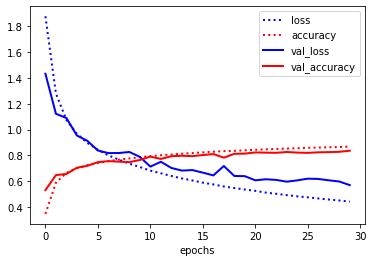

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_61 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_62 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_63 (Dense)             (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.Adagrad(lr=0.01),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model



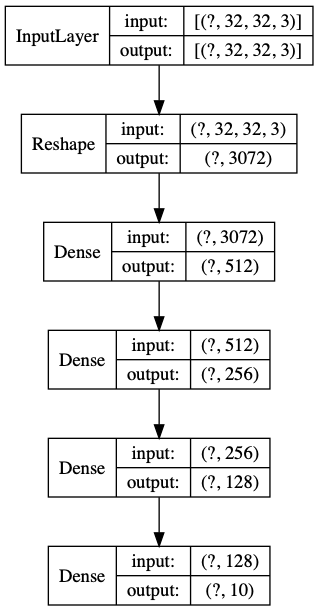

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

The performance is roughly the same after converting into gray. But the accuracy is betther at the very begining epoch. This means that the color information doesn't help to classify.  (length: 185)



Max val score: 83.74%


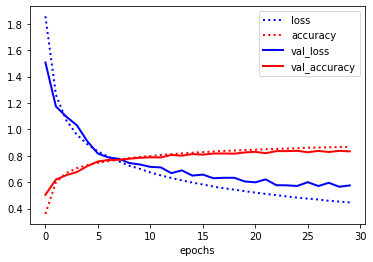

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_65 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_66 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_67 (Dense)             (None, 10)                1290      
Total params: 690,314
Trainable params: 690,314
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

When I only add BatchNormalization(), the performance improve quite a lot in the beginning, and there is less fluctuation of validation loss. But after I add Dropout layer, the model performs worse. Then L1/L2 regulation dosen't help a lot. So I only remain BatchNormalization().  (length: 281)



Max val score: 81.76%


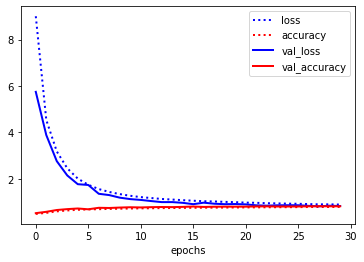

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.Adagrad(lr=0.01),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Firstly, I tried the LeNet-5 Architecture with BatchNormalization(), it can get 90.5% accuracy with 'Adam' optimizer. Then I tried VGG like architeture, without dropout layer overfitting happens very fast. The accuracy on train dataset has reached nearly 100%, but the accuracy of validation dataset doesn't improve. The final model can get a accuracy of 95.2% after 30 epoch. (I also add another convolutional layer, but not help, so I delete it)  (length: 449)



Max val score: 95.20%


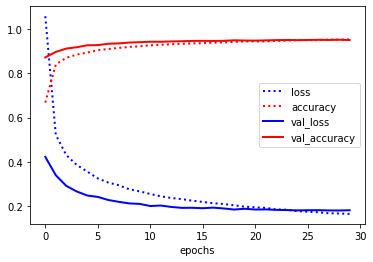

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)       

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    # model.add(layers.Conv2D(128, (3, 3), activ

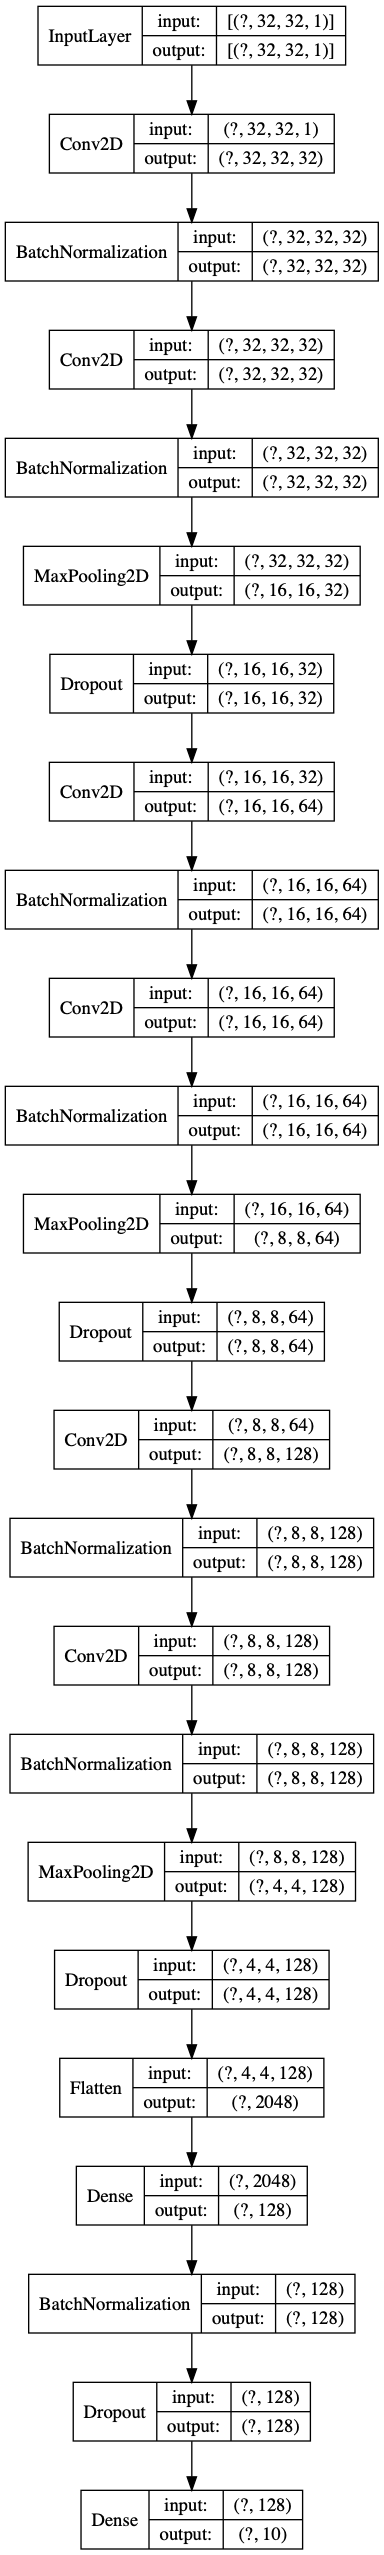

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

The accuracy is lower after using data augmentation. 'featurewise_center', 'flip' and 'rotation' have really bad performance. 'Rotate' doesn't help neither. Maybe it causes much more coofusion between 6 and 9. Relatively, 'width_shift', 'height_shift' and 'zoom' have less impact on the performance. The model performs badly at the beginning, but in the end it can get a accuracy of 91.8%.  (length: 391)



Max val score: 91.82%


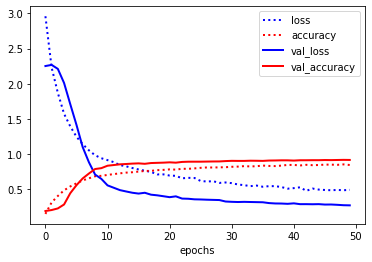


train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

Number '5' is often misclassified as '3', while '3' is also missclassified as '8'. Number '6' and '8' are often confused. Then I focus on number '8', and plot some misclassifications. Some is because there are other numbers in the same image; some is because  a lot of noisy, then image is blurry. There are also some "misclassifications" that I think is more close to the predicted class.  (length: 391)

Test score: 0.92%


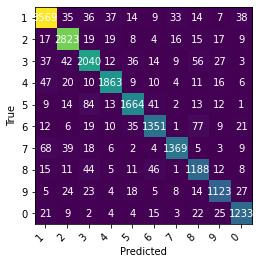

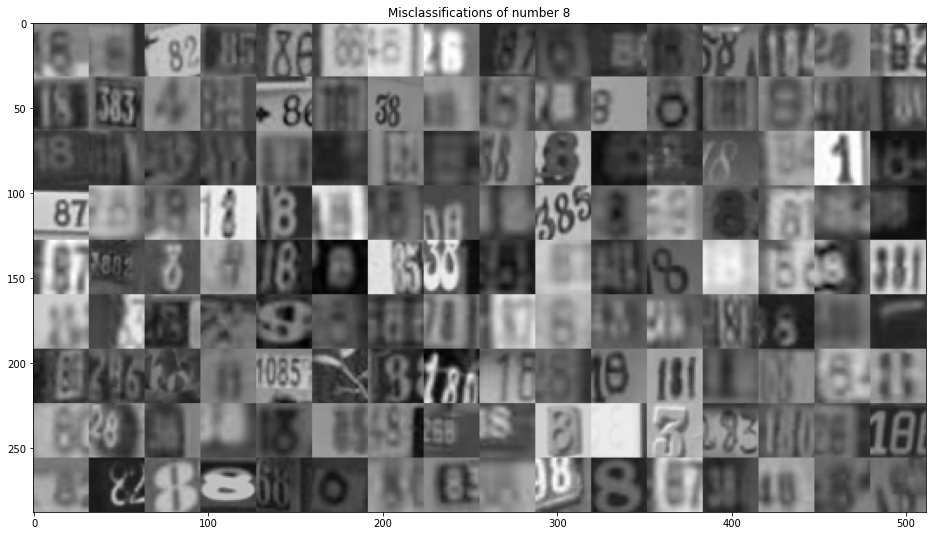

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

We can easily recognize the number in the output of the first convolutional layer. The bottom layer focus more on borders. And there are blank filters at the 1st layer. On the top layer, it's harder to recognize it by human eyes. It means the top layer also focus on other features than the shape of numbers.   (length: 311)



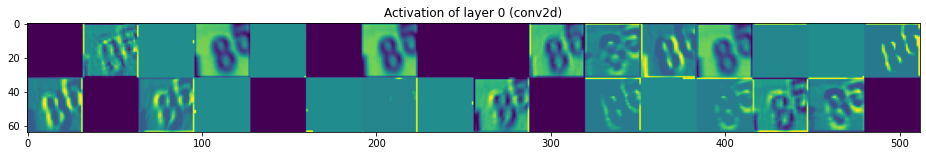

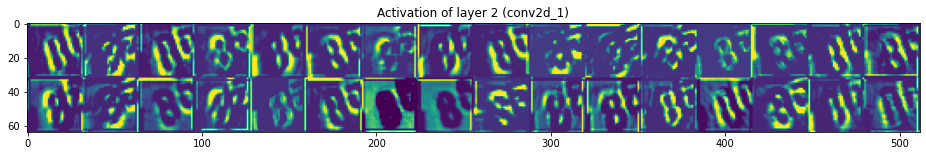

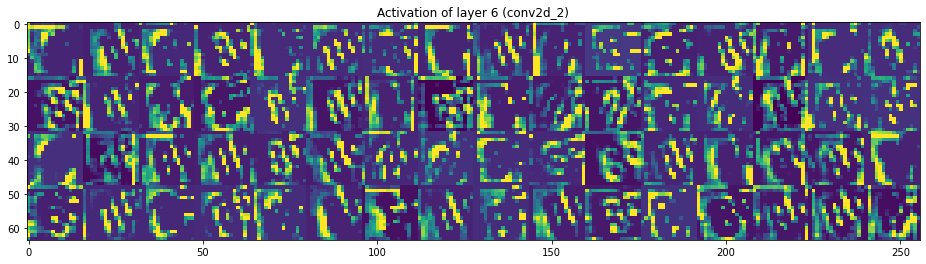

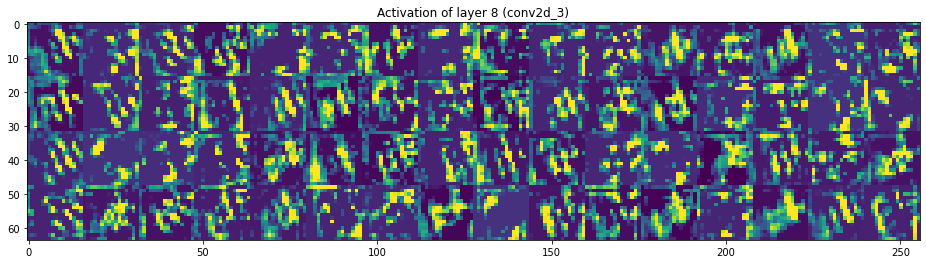

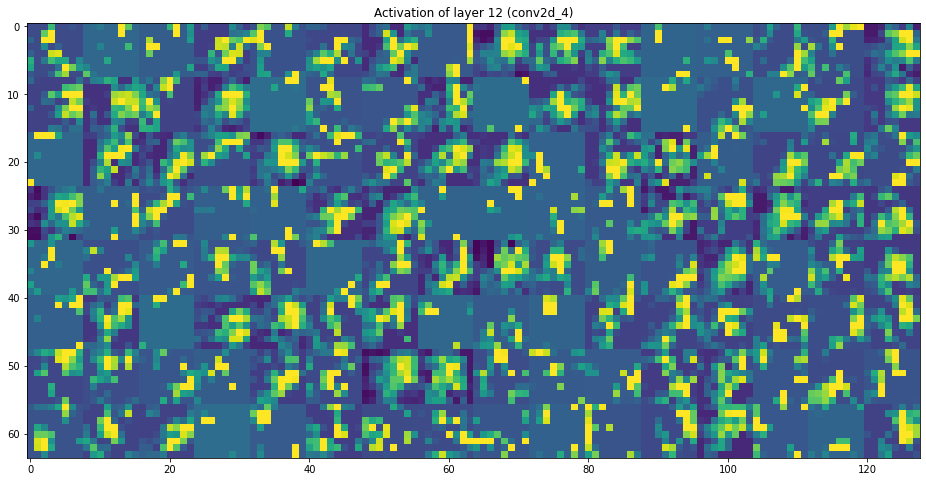

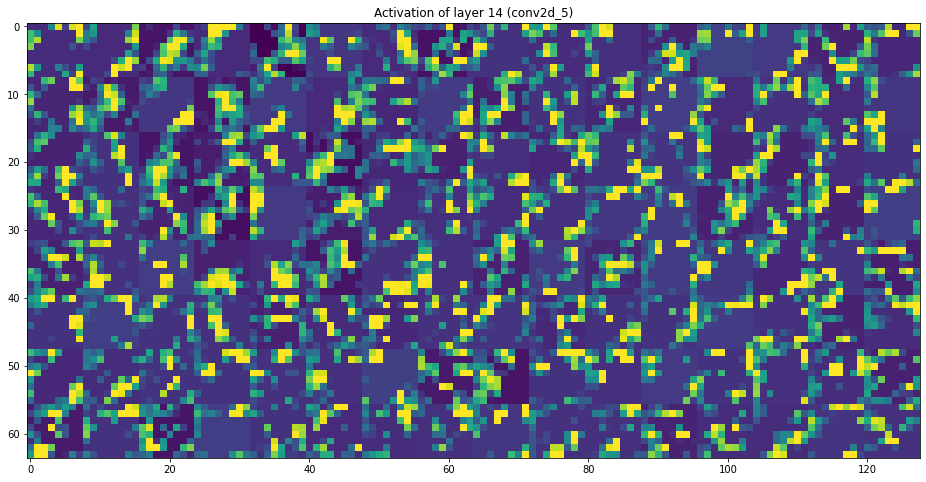

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

Predicted:  8


def plot_3_3():
    K.clear_session()
    model = load_model_from_file(base_dir, "model_2_2")
  
    original_img = np.uint8(255 * X_test[0])
    img = X_test_pre[0].reshape(32,32,1)
    x = np.expand_dims(img ,axis=0)
    # x = preprocess_input(img)
    pred = model.predict(x)
    class_idx = np.argmax(pred)
    print("Predicted: ", (class_idx + 1)%10 )
    
    image_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer('conv2d_5')

    grads = K.gradients(image_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(128):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.imshow(heatmap, cmap='gray')
    ax.s

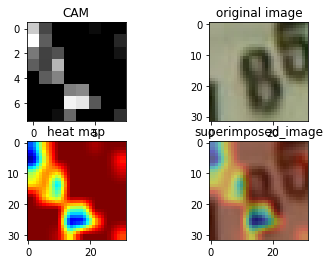

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

The val_accuracy is stuck around 60% when freezing all layers in vgg16. But if I unfreeze the block 5(last 3 convolutional layers), the val_accuracy reaches 84.6%. The val_accuracy varies a littel after 10 epoch, while the val_loss increases. If also unfreezing block 4, the accuracy can reach 92.6%. If a model has more parameters to be trained, it can get higher accuracy.  (length: 376)



Max val score: 92.94%


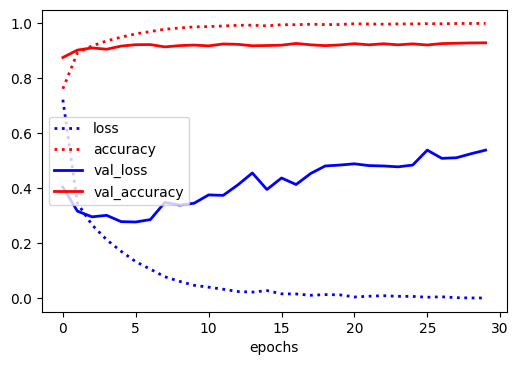

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 13,113,098
Non-trainable params: 1,735,488
_________________________________________________________________
None


def build_model_4_1():
    model_vgg = models.Sequential()
    model_vgg.add(VGG16(include_top = False, weights = 'imagenet', input_shape=(32, 32, 3), pooling='max'))
    con_indx = [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]
    for i in con_indx[:7]:
        layer = model_vgg.layers[0].layers[i]
        layer.trainable = False
        # print(layer.name)

    model_vgg.add(layers.Flatten())
    model_vgg.add(layers.Dense(256, activation='relu'))
    model_vgg.add(layers.Dense(10, activation='softmax'))
    model_vgg.compile(optimizer=optimizers.Adagrad(lr=0.01),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model_vgg



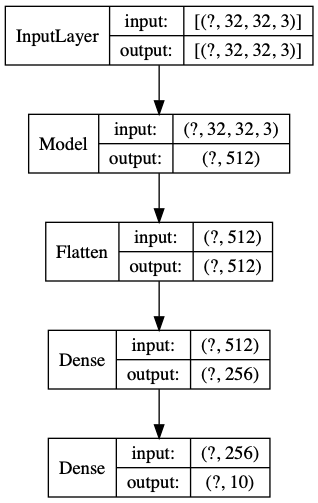

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I tried Randomforest, SVM and DecisionTree with and without a scaler. There isn't much difference between them. DecisionTree can get a accuracy of 92.2%, worse than the best model, which can get the accuracy of 95.2%. But the accuracy is really close to what I get in model_4_1(92.6%). The results show that convolutional layers are good at feature extraction.  (length: 362)

Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=1))])
def store_embeddings():
  model = load_model_from_file(base_dir, "model_4_1")
  print("Embeddings start!")
  conv_layer = model.get_layer('vgg16')
  train_all = conv_layer.predict(X_train_all)
  train_output = conv_layer.predict(X_train)
  val_output = conv_layer.predict(X_val)
  test_output = conv_layer.predict(X_test)

  store_embedding(train_all, 'vgg_train_all')
  store_embedding(train_output, 'vgg_train')
  store_embedding(val_output, 'vgg_val')
  store_embedding(test_output, 'vgg_test')
  print("Embeddings have been stored!")

def evaluat

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 27.63 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
